# HSCT survival: gradient boosting decision tree ensemble model

## Notebook set-up

In [1]:
import pickle
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

# Data files
raw_training_data_file=f'{config.DATA_PATH}/raw/train.csv'
raw_testing_data_file=f'{config.DATA_PATH}/raw/train.csv'

# Model files
naive_model_file=f'{config.MODELS_PATH}/05.2-XGBoost_naive.pkl'
tuned_model_file=f'{config.MODELS_PATH}/05.2-XGBoost_tuned.pkl'

retune_model=False

## 1. Load data

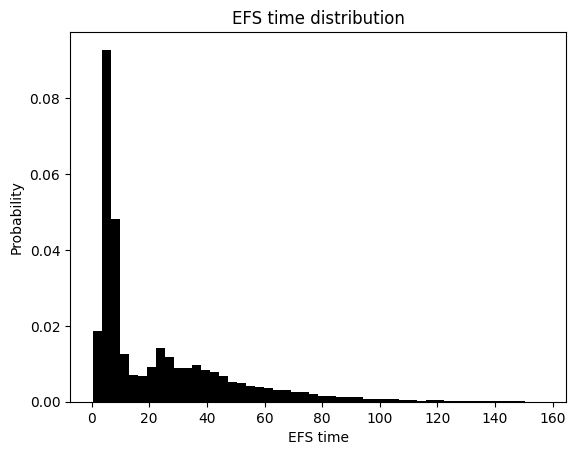

Training features: (28800, 59)


In [2]:
df=pd.read_csv(raw_training_data_file, index_col='ID')

plt.title('EFS time distribution')
plt.hist(df['efs_time'], density=True, bins=50, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {df.shape}')

## 2. Encode features

In [3]:
# Preserve un-encoded race group for stratified C-index scoring
race_group=df['race_group']

# Encode
df=pd.get_dummies(df, drop_first=True)

# Clean up column names
df.columns=df.columns.str.replace('[\\[\\]<]', '', regex=True)

# Add back race_group
df['race_group']=race_group

## 3. Train-test split

In [4]:
training, testing=train_test_split(df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=df.columns)
testing_df=pd.DataFrame(testing, columns=df.columns)

training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

## 4. Naive model

In [5]:
# XGBoost Model
xgb_params={
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 315
}

## 5. Fit and evaluate naive model on test set

In [ ]:
# Train on the complete training set
training_features=training_df.drop(['efs', 'efs_time'], axis=1)
training_labels=training_df['efs_time']
dtraining=xgb.DMatrix(training_features, label=training_labels)

naive_model=xgb.train(
    xgb_params,
    dtraining,
    num_boost_round=1000,
    evals=[(dtraining, 'training')],
    early_stopping_rounds=10,
    verbose_eval=0
)

# Save the model
with open(naive_model_file, 'wb') as output_file:
    pickle.dump(naive_model, output_file)

# Make predictions for the test set
testing_features=testing_df.drop(['efs', 'efs_time'], axis=1)
testing_labels=testing_df['efs_time']
dtesting=xgb.DMatrix(testing_features, label=testing_labels)
naive_predicted_efs_time=naive_model.predict(dtesting)

# Score the predictions
scoring_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

scoring_results=helper_funcs.score_predictions(
    model_description='Naive',
    predictions=naive_predicted_efs_time,
    labels_df=testing_labels_df,
    race_group=testing_race_group,
    results=scoring_results
)

## 6. Hyperparameter tuning

Current search space runs at about a minute per iteration.

In [ ]:
# Train or load model as desired
if retune_model == True:

    # Define the hyperparameter search space
    search_space={
        'objective': ['reg:squarederror'],
        'eval_metric': ['rmse'],
        'seed': [315],
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [4, 8, 16],
        'gamma': [1, 0.1, 0.01],
        'subsample': [0.3, 0.6, 0.9]
    }

    results, tuned_model=helper_funcs.xgb_hyperparameter_search(
        search_space,
        training_df
    )

    # Save the tuned model
    with open(tuned_model_file, 'wb') as output_file:
        pickle.dump(tuned_model, output_file)
    
elif retune_model == False:

    with open(tuned_model_file, 'rb') as input_file:
        tuned_model=pickle.load(input_file)

## 7. Evaluate tuned model on test set

In [ ]:
# Make predictions on the training set
tuned_predicted_efs_time=tuned_model.predict(dtesting)

scoring_results=helper_funcs.score_predictions(
    model_description='Tuned',
    predictions=tuned_predicted_efs_time,
    labels_df=testing_labels_df,
    race_group=testing_race_group,
    results=scoring_results
)

## 8. Model comparison: test set performance

### 8.1. Scores

In [ ]:
scoring_results_df=pd.DataFrame.from_dict(scoring_results)
scoring_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,Naive,24.289595,0.588931,0.477119
1,Tuned,22.819376,0.588354,0.474255


### 8.2. Performance evaluation plots

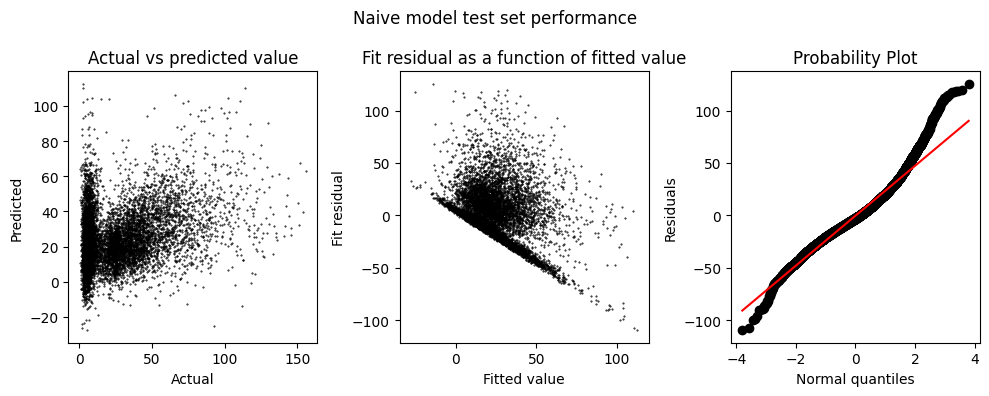

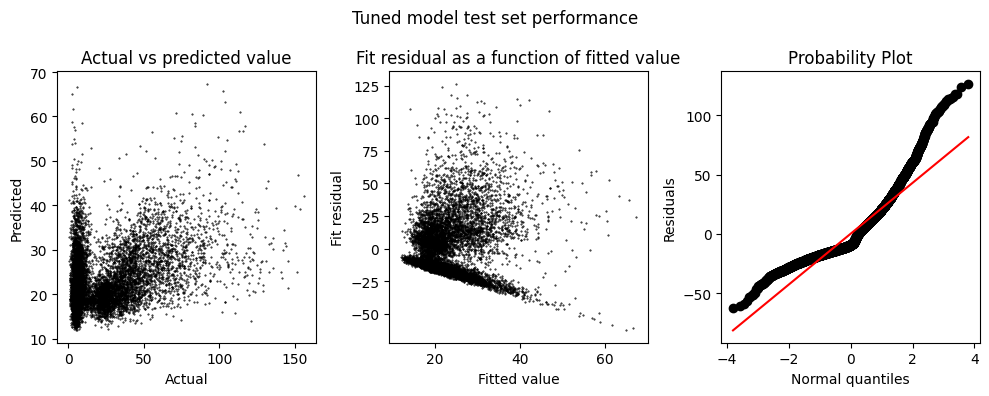

In [ ]:
plot_funcs.prediction_eval_plot(
    'Naive model test set performance',
    naive_predicted_efs_time,
    testing_df['efs_time']
).show()

plot_funcs.prediction_eval_plot(
    'Tuned model test set performance',
    tuned_predicted_efs_time,
    testing_df['efs_time']
).show()